Philippe Joly 2025-08-14

# Test Data Overview

looks at the structure/patterns of generated test data

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import sys
import os
import pandas as pd
sys.path.append(os.path.expanduser('~'))

## Check Test Time Stream

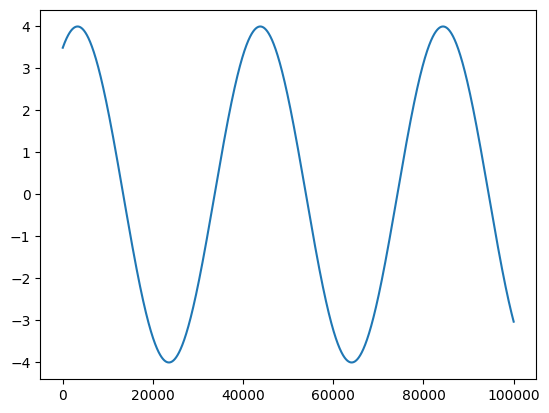

In [18]:
fn = "/scratch/philj0ly/test_08_25/pfb_input_job_1.npz"
with np.load(fn) as f:
    ts = f["ts"]
t0 = 250000
dt = 100000
plt.plot(ts.flat[t0:t0+dt])

plt.show()

## PFB Pipeline Test

In [3]:
fns = [
    "/scratch/philj0ly/test_08_25/test_constant_2100_64.npz", # generated constant time stream 
    "/scratch/philj0ly/test_08_25/test_uniform_2100_64.npz", # generated random (uniform distribution) time stream
    "/scratch/philj0ly/test_08_25/test_gaussian_2100_64.npz", # generated gaussian time stream
    "/scratch/philj0ly/test_08_25/test_sine_2100_64.npz", # Generated Sinusoidal 5 kHz time Stream
]

fns = [
    "/scratch/philj0ly/test_08_25/test_constant_2100_1024.npz", # generated constant time stream 
    "/scratch/philj0ly/test_08_25/test_uniform_2100_1024.npz", # generated random (uniform distribution) time stream
    "/scratch/philj0ly/test_08_25/test_gaussian_2100_1024.npz", # generated gaussian time stream
    "/scratch/philj0ly/test_08_25/test_sine_2100_1024.npz", # Generated Sinusoidal 5 kHz time Stream
]

# fns = [
#     "/scratch/philj0ly/test_08_25/test_constant_2100_5096.npz", # generated constant time stream 
#     "/scratch/philj0ly/test_08_25/test_uniform_2100_5096.npz", # generated random (uniform distribution) time stream
#     "/scratch/philj0ly/test_08_25/test_gaussian_2100_5096.npz", # generated gaussian time stream
#     "/scratch/philj0ly/test_08_25/test_sine_2100_5096.npz", # Generated Sinusoidal 6 kHz time Stream
# ]

pu = ['constant time stream','uniform distribution', 'Gaussian distribution', 'Sine time stream']

spectra = []
avg_spectra = []

osamp = 1024

df_record = 125e6/2048 # (Hz) frequency range / # of channels
df = df_record / osamp # <- OSAMP

for i, fn in enumerate(fns):
    with np.load(fn) as f:
        spectra.append(np.ma.MaskedArray(data=f['data'], mask=f['mask']))
        avg_spectra.append(np.mean(np.abs(spectra[i]), axis=3))
        print(pu[i], 'spectrum shape:', spectra[i].shape)

constant time stream spectrum shape: (2, 2, 1024, 20)
uniform distribution spectrum shape: (2, 2, 1024, 20)
Gaussian distribution spectrum shape: (2, 2, 1024, 20)
Sine time stream spectrum shape: (2, 2, 1024, 20)


In [4]:
df*103

6139.278411865234

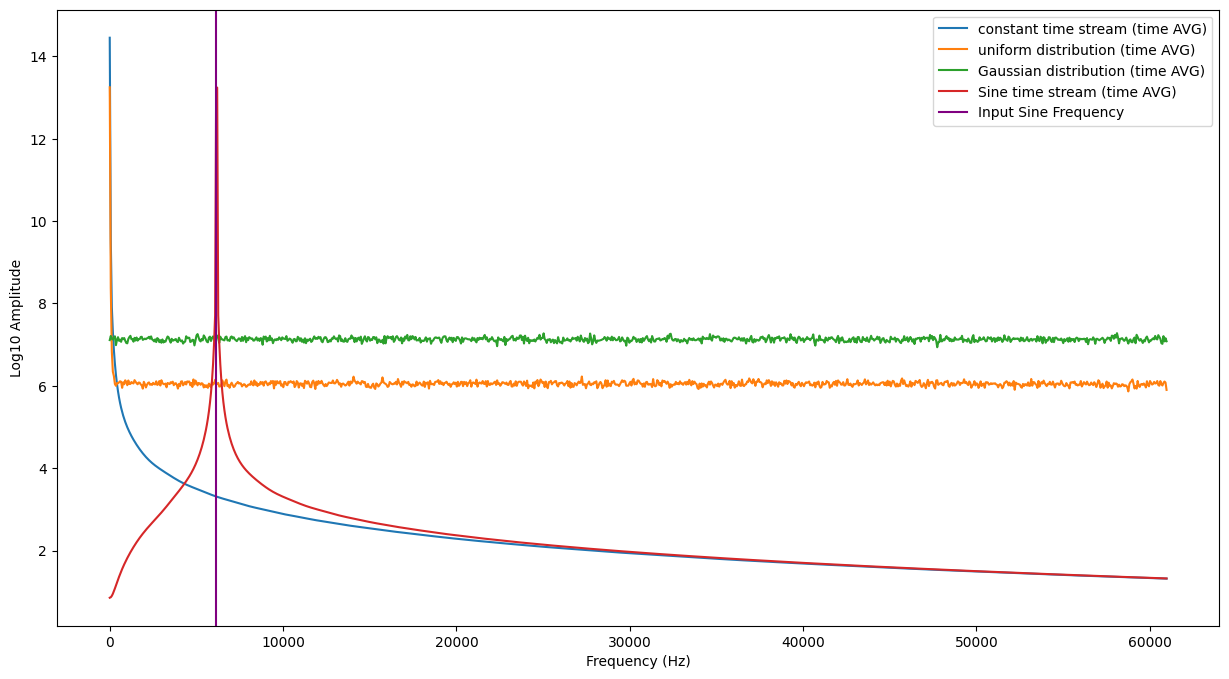

In [5]:
t = 0
single_t = False

log = True
avg = True

freqs = np.arange(spectra[0].shape[2])*df

plt.figure(figsize=(15,8))

for i in range(len(fns)):
    # if i!=0:
    #     continue
    if log:
        if single_t:
            plt.plot(freqs, np.log10(np.abs(spectra[i][0,0,:,t])), label=pu[i])
        if avg:
            plt.plot(freqs, np.log10(avg_spectra[i][0,0]), label=f"{pu[i]} (time AVG)")
    else:
        if single_t:
            plt.plot(freqs, np.abs(spectra[i][0,0,:,t]), label=pu[i])
        if avg:
            plt.scatter(freqs, avg_spectra[i][0,0], label=f"{pu[i]} AVG")

    # break

plt.axvline(6139, color='purple', label="Input Sine Frequency")

plt.xlabel('Frequency (Hz)')  
if log:
    plt.ylabel('Log10 Amplitude')
else:
    plt.ylabel('amplitude')

# plt.xlim(5000,7000)
plt.legend()

plt.show()

| Input Time Stream | Expected Output | Actual Output | Test Passed |
| :---------------- | :-------------: | :-----------: | :---------: |
| Zero | Zero | Zero | Yes|
| Constant              |  Delta at 0 Hz  | Spike at 0 Hz | ~ |
| Uniform | White Noise | White Noise (Spike at 0) | Yes |
| Gaussian | White Noise | White Noise | Yes |
| Sinusoidal | Delta at Frequency | Spike at Frequency | ~ |

## Back to ts

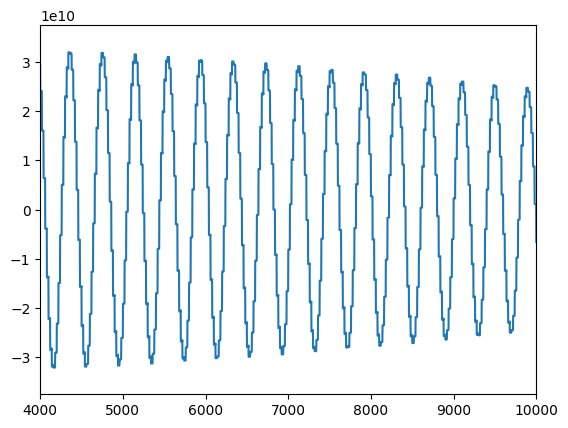

In [6]:
from scipy.fft import rfft, irfft
x = irfft(spectra[3][0,0], axis=0)
plt.plot(x.flat)
plt.xlim(4000,10000)
plt.show()

In [7]:
x.shape

(2046, 20)

In [8]:
from scipy.fft import rfft, irfft
def sinc_hamming(ntap,lblock):
    N=ntap*lblock
    w=np.arange(0,N)-N/2
    return np.hamming(ntap*lblock)*np.sinc(w/lblock)
    
def get_matft(nslice,nchan=2049,ntap=4):
    nn=2*(nchan-1)
    dwin=sinc_hamming(ntap,nn)
    cupy_win=np.asarray(dwin,dtype='float32',order='c')
    cupy_win=np.reshape(cupy_win,[ntap,len(cupy_win)//ntap])
    mat=np.zeros((nslice,nn),dtype='float32',order='c')
    mat[:ntap,:]=cupy_win

    # Frees memory
    cupy_win = None
    mat=mat.T.copy()
    matft=rfft(mat,axis=1)
    
    return matft
    
def calculate_filter(matft, thresh):
    filt = 1/np.conj(matft)

    if thresh>0:
        abs_mat_sq = np.abs(matft)**2
        filt *= abs_mat_sq/(thresh**2+abs_mat_sq)*(1.+thresh**2)
    
    return filt

def ipfb(dat,filt):
    dd=irfft(dat, axis=1)

    dd2=dd.T.copy()
    ddft=rfft(dd2, axis=1)

    ddft=ddft*filt

    res = irfft(ddft, n=dd.shape[0], axis=1)
    res=res.T
    return res

In [9]:
cut = 1
acclen = spectra[0].shape[-1]-2*cut
filt_thresh = 0
nchan = 5096

matft = get_matft(acclen+2*cut, nchan=nchan)
filt = calculate_filter(matft, filt_thresh)

## File to Time Stream Test

In [ ]:
from baseband_data_classes import get_header, BasebandFloat

In [ ]:
path_dir = '/scratch/philj0ly/test_baseband_data2'
path_dir = '/scratch/philj0ly/simple_test_data'
fn = '17214/1721400005.raw'
f_path = os.path.join(path_dir, fn)

header = get_header(f_path, verbose=True)

In [ ]:
# max is 83056
bb = BasebandFloat(f_path, readlen=1000)
print('Data shapes:', bb.pol0.shape, bb.pol1.shape)

In [ ]:
f_bin = 125*1e6 / 2048
npol = 2

chnls = header['channels'].shape[0]
packs = bb.pol0.shape[0]

spectrum = np.zeros((npol, packs, chnls), dtype='complex64')
freqs = []
for i in range(chnls):
    freqs.append(header['channels'][i]*f_bin)
    
    for j in range(packs):
        spectrum[0, j, i] = np.abs(bb.pol0[j,i])
        spectrum[0, j, i] = np.abs(bb.pol1[j,i])

    if i % 10 == 0:
        print(f"{i}/{chnls} Channels Processed")
        
freqs = np.array(freqs)   

In [ ]:
plt.plot(freqs*1e-6, spectrum[0,300])
plt.xlabel("Frequency (MHz)")
plt.ylabel("Ampltitude")
plt.show()